# Introduction

Speech to text (STT) systems rely on massive data sets for initial training, and relatively prohibitively sized datasets to fine tune for deployment.  This seems to hold true even for simple models looking to recognize "yes/no" responses, though most certainly for yet modest 12 word targets; as recently examined in detail by Francis Tyers and Josh Myer (Tyers et al 2021) [[1]](#1). The authors suggest:  

> "*Time-to-deployment* is a consideration that may be difficult to quantify, but often outweighs any other STT attribute in both academia and production settings. Time to deployment is the amount of time it takes an engineer to deploy a model into a production pipeline."

Their technical report (as referenced above) focuses primarily on hyperparameter tuning, and the impact of imperfect autogenerated vs manually transcribed labeled data, for varying data set sizes, in the domain of training language specific models. I am working to, at least philosophically, extend their efforts into subject matter specific models, with a focus on automating much of the data generation process itself, as opposed to hyperparameter tuning.  

The ultimate realization of this experiment is a system which can automatically train itself for domain specific speech recognition using the same presentations we use to train many humans on subject matter.  In fact I'm using an example presentation from this course for this project!   

More realistically my goals in this project are to automatically and economically enhance the decoding phase of transcription, and therefore ease "time to deployment" for these usecases, using videos with slides as input. 


# Approach

### General Design

I began this project with the broad goal of combining computer vision (CV) text extraction with STT to enhance the accuracy of both.  I needed to link the training/operation of both (CV and STT) so that the overarching system could:

1. Identify words CV or STT struggled with which the other didn't  
2. Somehow support the stronger system with the weaker one  


In order to link CV with STT it seemed that I would need to either build an "autoencoder analogue" where they are passing data back and forth directly, or find a way to have them communicate asynchronously.  


Towards the more feasible asynchronous end I first compared two of the more popular opensource STT frameworks: Vosk and Deep Speech [[2]](#2).  


Vosk is a python wrapper for the Kaldi engine which may be the most generally performant available as source code [[3]](#3). While it is possible to add n-grams, I was unable to find any option for doing so besides the command line or direct modification of sourcecode to get at the underlying engine [[4]](#4), or by writing custom parsing for specific phrases myself [[5]](#5), which defeats one of they key goals of the project: automation.  

* Ideally the scorer, which is the heart of the decoder turning characters into actual words, is paired with alpha and beta coefficients which inform the relative weights of words vs language (context) when the decoder "chooses" a word.  See step 4b in the outline below        


A spinoff from Deep Speech: "Coqui" however offers a pipeline for incorporating hotword weights to trained models, as well as a dedicated subsystem for processing "typical phrases" and incorporating them into the testing process, with a python API. Additionally, it is possible to add and remove hotwords programmatically [[6]](#4), which offers the possibility of short interval post training transcription enhancement using output from the OCR system, with additional inference.  


* The key difference between hotwords and phrases added to the scorer is that while both are used by the separate inference n-gram probability process (kenLM in this case) that likelihood estimation can't handle n-grams post training.  A hotword biases the post Deep Speech RNN model (below and see Beta coefficient in [[Deep Speech equation]](#deep_prob)) by weighting the likely combination of characters from Deep Speech.  The n-gram probabilities have to be built, and are far more computationally demanding.  
 

The Deep Speech Model: [[7]](#7)

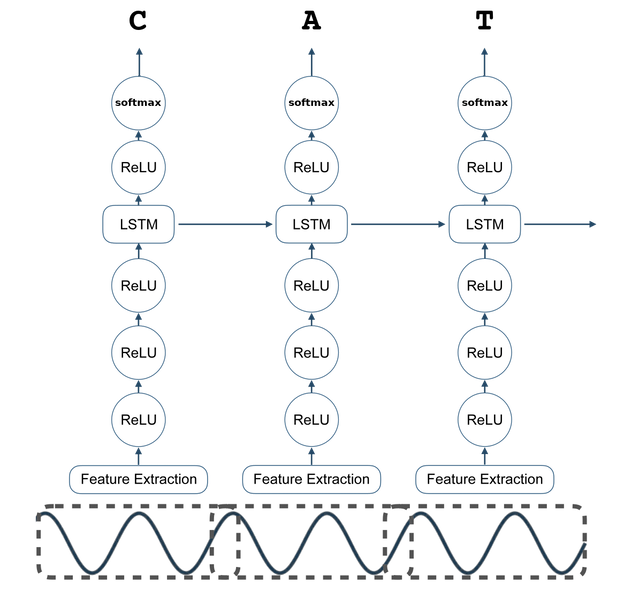

We have enough background now to outline the general architecture for this project (An explanation of how I use OCR output to determine topics and generate a subject matter relevant vocabulary follows):  
<ol>
  <li>Segment video into 15s intervals so that the CV and STT systems have a reference "frame" (for enhanced post-training inference using hotwords.  See video.py)
  <ol type="a">
    <li>Segments are frequency/framerate locked to target STT system specification, and split into audio and video files</li>
  </ol>
  </li>
  <li>Transcribe each segment for training STT (automating as much as possible)
    <ol type="a">
      <li>A portion of test/train/val audio segments are roughly transcribed by Google, then manually corrected (see Transcript.py)</li>
    </ol>
  </li>
  <li>Extract text from images, indexed by time (see imageToText.py)
    <ol type="a">
      <li>Generate Scorer
        <ol type="i">
          <li>Frames are extracted (as numpy arrays) at a tunable interval and fed to OCR.  *see 'build_scorer' in imageToText.py*</li>
          <li>OCR response is converted to topics *see topic abstraction below and get_topics in imageToText.py*</li>
          <li>Wikipedia is asked for relevant articles *see topic expansion below and get_wiki_articles in imageToText.py*"</li>
          <li>Relevant articles pass through a series of filters to remove artifacts, etc, and sentences are finally generated for the scorer file *see to_sentences in imageToText.py* </li>
          </ol>
        </li>
        <li>Generate Hotwords *not fully implemented*
          <ol type="i">
            <li>Frames are extracted (as numpy arrays) <b>at a high rate</b> and fed to OCR.</li>
            <li>OCR response is filtered, stop words are maintained, n-gram "frequency" between frames is leveraged to "take the average" of OCR predictions</li>
            <li>To enhance relevance topics are selected to favor OCR derived words which appear in most common n-wikipedia articles for that time period</li>
          </ol>
        </li>
    </ol>
  </li>
  
  <li>Enhance inference with scorer
    <ol type="a">
      <li>Determine the relative weights of language (alpha) vs words (beta)<a href="#8">[8]</a> </li>
      <li>Generate a n-gram probability model from our brand new scorer corpus using kenlm<a href="#9">[9]</a></li>
      <li>Scorer is used to contextualize character encoding by the STT into actual spoken language (language model and word score [[Deep Speech equation]](#deep_prob))</li>
    </ol>
  </li>
  <li>Enhance inference with hotwords *not implemented*
    <ol type="a">
      <li>Pair time segmented, n-gram filtered OCR output (generated hotwords)with time-segmented audio clips.  Essentially "you are more likely to hear these words during this clip</li>
    </ol>
  </li>
</ol>


 



### Topic abstraction

Given that we want to approximate the subject matter content of a video to enhance general word level sequence probability estimation (in abstract), it falls on this process to extract the "essence" of a video.  That extraction presents some difficulties.  

Tesseract output is in the form of characters and spacing to convey position, and it is to date in this project somewhat chaotic. 

Leaving aside the details for cleaning the OCR output, it's tempting to assume that the top of a video with a slideshow is going to be a relevant topic heading.  However it is reasonably likely to be some interface (such as MS Powerpoint), or any other irrelevant text.  Further the titles of slideshows don't always reflect the content. [[OCR Example]](#OCR_1) 

Another consideration is that given we want to know what's being discussed, we want to incorporate the amount of time slides are on screen into our approximation of relevant words and phrases.  

To those ends (after cleanup) I first remove stopwords and identify bigrams (get_collocations in imageToText.py) using nltk and the likelihood ratio (of one sequence of characters following another given the OCR output).  This both helps to filter meaningless combinations of characters, and increases the probability that we will select phrases present on multiple slides or for a long period of time on screen. 

I then take a count of how many times those phrases appear in the top 5 lines of what has been filtered to be likely text, and not artifacts.  This further weights towards time on screen and potential slide headings, while allowing for additional common phrases to influence the output.  

Additionally we select only topics with counts above the mean (justified in topic expansion below). See get_topics_from_ocr_text in imageToText.py


### Topic Expansion

Depending on a few tuning parameters (see get_wiki_suggestions in imageToText.py), I then use the frequency ranked, "header weighted" topics to leverage wikipedia search so as to expand the potentially relevant range of topics as a crude form of abstract categorization.  A sample response for 'matrix dimensions' yields ['Confusion matrix', 'Rotation matrix', 'Matrix norm', 'Covariance matrix', 'Sparse matrix'].  Again here the more frequent, more likely header "topics" influence the scorer composition more than other terms by including more of the wiki search results into scorer sentence generation.  

For example taking the first course lecture on PCA as input the top  ranked topic proposals are

<table>
  <tr><td>covariance, matrix</td>      <td> 20</td></tr>   
  <tr><td>matrix, dimensions</td>      <td> 17</td></tr>  
  <tr><td>check, matrix</td>           <td> 16</td></tr>   
  <tr><td>purge, eigenvalues</td>      <td> 14</td></tr>  
  <tr><td>sample, covariance</td>      <td> 12</td></tr>  
  <tr><td>principal, component</td>    <td> 11</td></tr>    
  <tr><td>linear, algebra</td>         <td> 9</td></tr>   
  <tr><td>conceptual, information</td> <td> 4</td></tr>
  <tr><td>value, decomposition</td>    <td> 3</td></tr>   
  <tr><td>office, hours</td>           <td> 3</td></tr>   
  <tr><td>dimensional, space</td>      <td> 1</td></tr>  
</table>


With a mean frequency of 11, it pains me to lose "linear algebra", and "value decomposition", but selecting only those at or above the mean is a reasonably relevant list for that lecture.  You can also see hints of the previous weighting for topics given "dimensional space" appears multiple times in the lecture slides, but infrequently towards the top of OCR "lines of text"

The wikipedia search process with no prefernence given to frequency beyond the previous filtering (in topic selection) the articles used to generate a scorer file are {'purge eigenvalues', 'covariance matrix', 'matrix dimensions', 'check matrix', 'sample covariance'} 

The expanded search set is {'confusion matrix', 'viktor ambartsumian', 'parity-check matrix', 'rotation matrix', 'cornelius lanczos', 'estimation of covariance matrices', 'purge eigenvalues', 'covariance', 'covariance matrix', 
'matrix norm', 'hamming code', 'matrix dimensions', 'check matrix', 'sample mean and covariance', 'cross-covariance matrix', 'low-density parity-check code', 'n-electron valence state perturbation theory', 'sample covariance'}

While we didn't learn about Soviet Armenian Astrophysicists in that first lecture, this is a reasonably relevant list.  

The summaries for those topics are retrieved, parsed, and pushed through a more intensive filter than generally employed thereafter, using a tunable threshold for doc2vec similarity (filter_by_similarity in imageToText.py). The result of that process becomes the core anchor to "stay on subject" as the dictionary is constructed.  

From there in the ideal case we would only retrieve data from wikipedia which passes our word2vec filter.  There are two problems I am working to overcome before I can do that however.  See [[Trie Data Issues]](#Trie_data_issues).  

As those issues remain unresolved once the algorithm finds something approximating "global minimum" search parameters are progressively expanded in a few different ways to ensure that we have a corpus of sufficient size, and more than just specialized text, in a process which probably has a better name but I'm calling "reverse annealing" for now.  

"Reverse Annealing":
In the beginning text acquisition is tightly controlled, primarily through 
doc2vec, so that a base of relevant subject matter is built up.

As it becomes more difficult to find relevant text, restrictions on search and 
relevance are loosened.

The ideal arc approximates n_collocations = 3ln(i+1) where i is the index of search iterations.  To avoid local minima when we stop generating new topics 3 strategies are employed in order, with an additional 4th given the issues discussed above:

1st strategy: use entire pages for word2vec

2nd strategy: use entire pages + all previously searched documents

3rd strategy: sample 3000 lines of text at random from the corpus for word2vec matching

4th strategy: scale the number of acceptable articles and suggestions the longer we have gone without new topics

This scaling is accomplished by adjusting a collocation coefficient (c in c*ln(i+ 1) for n_collocations), as well as the number of wikipedia search suggestions requested.  

The results of each stage are somewhat apparent in the [[Bag of Words]](#bow) examples for <10000 vs n-10000 lines of text.


 

A random sample of 10 lines thereby constructed for the scorer are (from the included 1_PCA.mp4_sentences.txt):  

<ul>
  <li>approximately third of bers doctoral students were women high proportion for mathematics</li> 
  <li>using mathematical notation if sample of observations on variable is taken from the population the sample mean is under this definition if the sample is taken from the population then the sample mean is as compared to the population mean of even if sample is random it is rarely perfectly representative and other samples would have other sample means even if the samples were all from the same population</li> 
  <li>in this graph variable nodes in the top of the graph are connected to constraint nodes in the bottom of the graph</li> 
  <li>lanczos resampling is based on windowed sinc function as practical upsampling filter approximating the ideal sinc function</li> 
  <li>polar decomposition if the matrix is nonsingular its columns are linearly independent vectors thus the gram schmidt process can adjust them to be an orthonormal basis</li> 
  <li>we can in fact obtain all four magnitudes using sums and square roots and choose consistent signs using the skew symmetric part of the off diagonal entries tr the trace of sgn sgn sgn alternatively use single square root and division tr this is numerically stable so long as the trace is not negative otherwise we risk dividing by nearly zero</li> 
  <li>the sukhatme test applies to two variances and requires that both medians be known and equal to zero</li> 
  <li>both forms are quite standard and there is no ambiguity between them</li> 
  <li>there is another important inequality where is the frobenius norm</li> 
  <li>it was first awarded in and is awarded every two years</li>
</ul>



### Environment

I began this project primarily on desktop and attempted to move to collab for training with GPUs.  However I couldn't get the python version to downgrade (to 3.6) for compatibility with Coqui/Deep Speech.  From there I built coqui into a docker container on an nvidia enabled system.  As such the pipeline isn't fully integrated as yet.  I am building text files on a more robust system (with an AMD GPU sadly), and pushing them to be run via command line on the Nvidia machine.  See coqui_commands.txt

# Data


<a name="OCR_1">OCR Example</a>

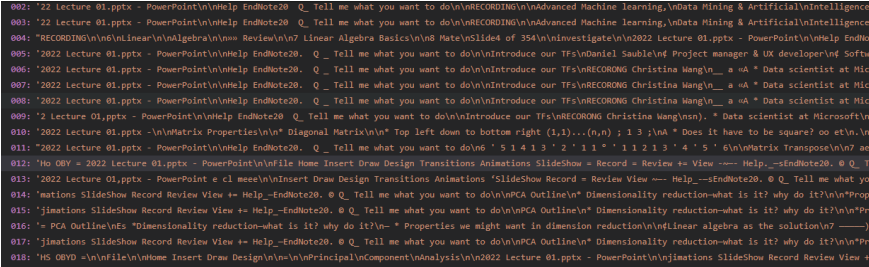



<a name="Trie_data_issues">Trie Data Issues</a>

1. The wikipedia responses often incorporate a lot of complex equations which are simply being stripped out.  I need a latex parser to translate them, which I may need to write myself.  In the meantime many sentences are grammatical attrocities.  Adding non-relevant text should help to smooth out these sentences to nowhere based on how the KenLM trie files are constructed: on the assumption that the point at which mathematical functions are "poking holes" in our grammar will be more random than general word sequences, so adding more normal speech helps to normalize the data over all  

2. I haven't been able to find a trie file knitter.  I'd like to generate the specialty language alone and knit it with a trie file built on a larger corpus.  As said file is a tree representing probabilities, I'm not certain one can easily incorporate what is essentially another distribution from a different space.  As such ATOW I'm generating a "mini-corpus" for testing and further development, while adding my generated subject matter only text to the LibriSpeech 2.4T corpus, and separately training for comparison.  This takes multiple days on the hardware available to me. 

 <a name="bow"></a>

# Results

The best result I have been able to achieve with transfer learning: there is a reason why I haven't mentioned transfer learning in this report yet.  The corpus simply isn't large enough, and I have yet to compare transfer learning using an hour of audio with a KenLM decoder against a pre-built general model as the decoder is taking ages to compile on my hardware.  That said coqui_run_3.txt is the result of 59 epochs run on 30 minutes of audio + transcribed text, retraining one RELU layer and the softmax, with a minimum Word Error Rate of 93% and a Character Error Rate of 68%.  

See coqui_run_3.txt for more details. 

Beyond that I am very pleased to report that prior to "strategy 4" (which will be removed when I finish knitting the output of this process with an existing large corpus) runs on 2 hours of lecture on PCA returns 83 articles with 78 of those being directly relevant to data science.  

I regret that I don't have more metrics to share at this time.  I am still in the "get the prototype working" stage prior to refinement and refactoring wherein I will incorporate true gradient descent using word and doc2vec, followed by descent using feedback from Coqui-Deep Speech.  

As previously discussed I will also use hotwords from sections of text to add and remove hotwords during transcription which should considerably boost accuracy, and feed that output back into "dictionary dilation" for more aggressive and accurate training dictionaries. 

I genuinely look forward to finishing this system in the coming weeks, and releasing it to the open source community in the hopes that others might find it useful.  

# Supplementary 

<a name="deep_prob">Deep Speech equation</a>[[8]](#8)

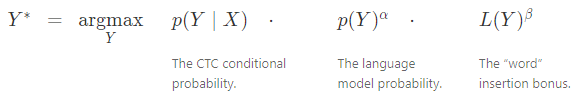

<a name="bow">BOW</a>

Included Corpus 10mb

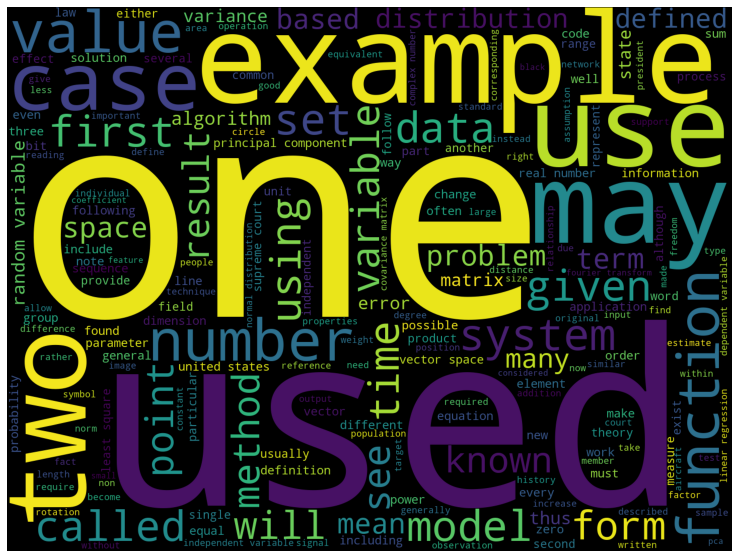

First 10k lines (pre finding global minimum)

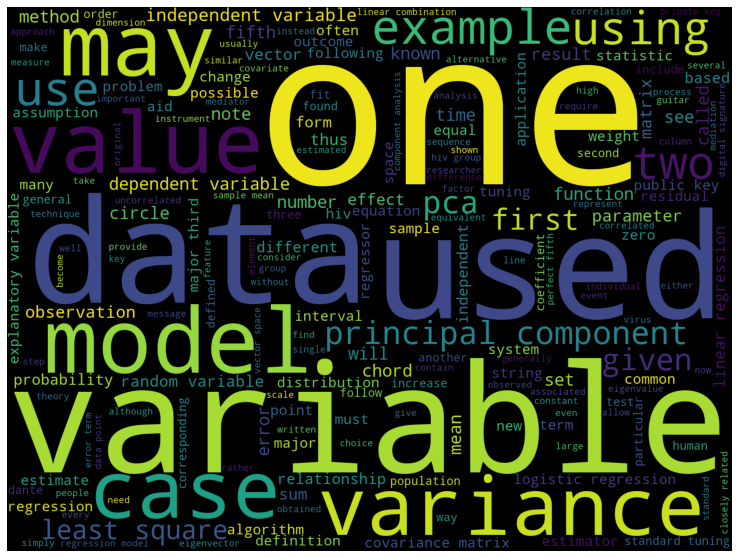

Last 10k lines (post "great expansion period")

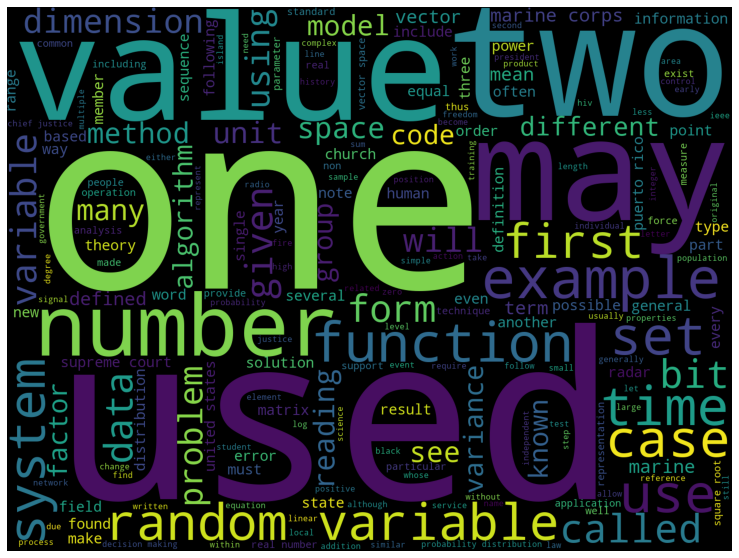


I have a fair bit of refactoring and integration to do to make this easy to use... The following file structure must be in place:     
-clips  
-articles  
-summaries  

In transcript.py run:

to get a dataframe for coqui training/transcripts to fix
- prep_coqui(\<video file path>)

after manually fixing transcripts
- cq_df = build_coqui_df(\<start of audio>, \<duration of audio>, \<audio clip duration>, '\<generated audio file name>')
 
generate a scorer file
- build_scorer('\<vid path>')





# References

<ol>
  <li>
    <a name="1" href="https://arxiv.org/abs/2105.04674">Tyers, F. M. and Meyer, J. (2021). What shall we do with an hour of data? speech recognition for the un and under-served languages of common voice. arXiv preprint arXiv:2105.04674.</a>
  </li>
  <li>
    <a name="2" href="https://deepspeech.readthedocs.io/en/r0.9/index.html">Mozilla Deep Speech</a>
  </li>
  <li>
    <a name="3">Trabelsi, Asma & Warichet, Sébastien & Aajaoun, Yassine & Soussilane, Séverine. (2022). Evaluation of the efficiency of state-of-the-art Speech Recognition engines. Procedia Computer Science. 207. 2242-2252. 10.1016/j.procs.2022.09.534.</a>
  </li>
  <li>
    <a name="4">https://github.com/alphacep/vosk-api/issues/55</a>
  </li>
  <li>
    <a name="5">https://github.com/alphacep/vosk-api/issues/740#issuecomment-954279447</a>
  </li>
  <li>
    <a name="6" href="https://stt.readthedocs.io/en/latest/Python-API.html?highlight=hotwords#native_client.python.Model.clearHotWords">Coqui Hotwords</a>
  </li>
  <li>
    <a name="7" href="https://deepspeech.readthedocs.io/en/r0.9/DeepSpeech.html">Mozilla Deep Speech model overview</a>
  </li>
  <li>
  <a name="8" href="https://distill.pub/2017/ctc/">Sequence modelling with CTC</a></li>
  <li><a name="9" href="https://kheafield.com/papers/avenue/kenlm.pdf">KenLM n-gram probability model</a></li>
</ol>